In [11]:
import argparse
import numpy as np
import cv2
import time
from PIL import Image
import concurrent.futures
from scipy import ndimage, signal
import matplotlib.pyplot as plt

In [12]:

def read_image(path):
    img = cv2.imread(path,0)

    return img.astype(np.int32)


In [13]:
def shift(block_l, block_r, block_size):
    dim1, dim2 = block_r.shape
    val = 10000
    ind = 0

    for i in range(dim2-2*block_size):
        current_diff = sad(block_l, block_r[:,i:i+2*block_size+1])

        if current_diff<val:
            val = current_diff
            ind = i+block_size

    return ind

In [14]:
def sad(block1, block2):
    return np.sum(np.abs(block1-block2))

def disparity(im1, im2, block_size=5, shift_size=80, name="Main Process"):
    print("Hi, I am "+name)

    dim1, dim2 = im1.shape

    if block_size is None:
        block_size = min(dim1//50, dim2//50)

    if shift_size is None:
        shift_size = block_size*10

    map = np.zeros((dim1, dim2))

    for i in range(dim1):
        for j in range(dim2):
            lim1 = j-shift_size if j-shift_size>=0 else 0
            lim2 = j+shift_size+1 if j+shift_size+1<dim2 else dim2
            lim3 = i if i>=0 else 0
            lim4 = i+1 if i+1<dim1 else dim1
            lim5 = j-block_size if j-block_size>=0 else 0
            lim6 = j+block_size+1 if j+block_size+1<dim2 else dim2

            if lim5==0:
                lim6=lim5+2*block_size+1

            if lim6==dim2:
                lim5=lim6-2*block_size-1

            map[i,j] = shift_size-shift(im1[lim3:lim4,lim5:lim6], im2[lim3:lim4,lim1:lim2], block_size)

    return map

def salt_pepper_noise():
    pass

In [15]:
if __name__ == "__main__":
    nb_processes = 7
    block_size = 5
    shift_size = 30
    median_kernel_size = 6
    path_color_map = "./Outputs/depth_color_map/depth_SAD.jpg"
    path_depth_map = "./Outputs/depth_map/depth_SAD.jpg"
    mode = "parallel" # "sequential"
    image_left = "SceneImages/SceneImages_left/left_1.bmp"
    image_right = "SceneImages/SceneImages_right/right_1.bmp"

    im1 = read_image(image_left)
    im2 = read_image(image_right)

    start = time.time()

    if mode=="parallel":
        param_list = []
        fac= im1.shape[0]//nb_processes

        for i in range(nb_processes-1):
            param_list.append([im1[i*fac:(i+1)*fac,:], im2[i*fac:(i+1)*fac,:], block_size, shift_size, "Process"+str(i)])

        param_list.append([im1[(nb_processes-1)*fac:,:], im2[(nb_processes-1)*fac:,:], block_size, shift_size, "Process"+str(nb_processes-1)])

        with concurrent.futures.ProcessPoolExecutor() as executor:
            futures=[]

            for param in param_list:
                p1,p2,p3,p4,p5=param
                futures.append(executor.submit(disparity, p1,p2,p3,p4,p5))
        
        depth=np.vstack(tuple([future.result() for future in futures]))
        
    else:
        depth = disparity(im1, im2, block_size, shift_size)

    duration = time.time()-start
    print("execution time: ", duration)
    depth = np.abs(depth)*255//np.max(np.abs(depth))
    depth = signal.medfilt(depth, kernel_size=median_kernel_size)
    cv2.imwrite(path_depth_map, depth)
    heatmap = cv2.applyColorMap(cv2.imread(path_depth_map), cv2.COLORMAP_JET)
    cv2.imwrite(path_color_map, heatmap)


Hi, I am Process0
Hi, I am Process1
Hi, I am Process2
Hi, I am Process3
Hi, I am Process4Hi, I am Process5

Hi, I am Process6


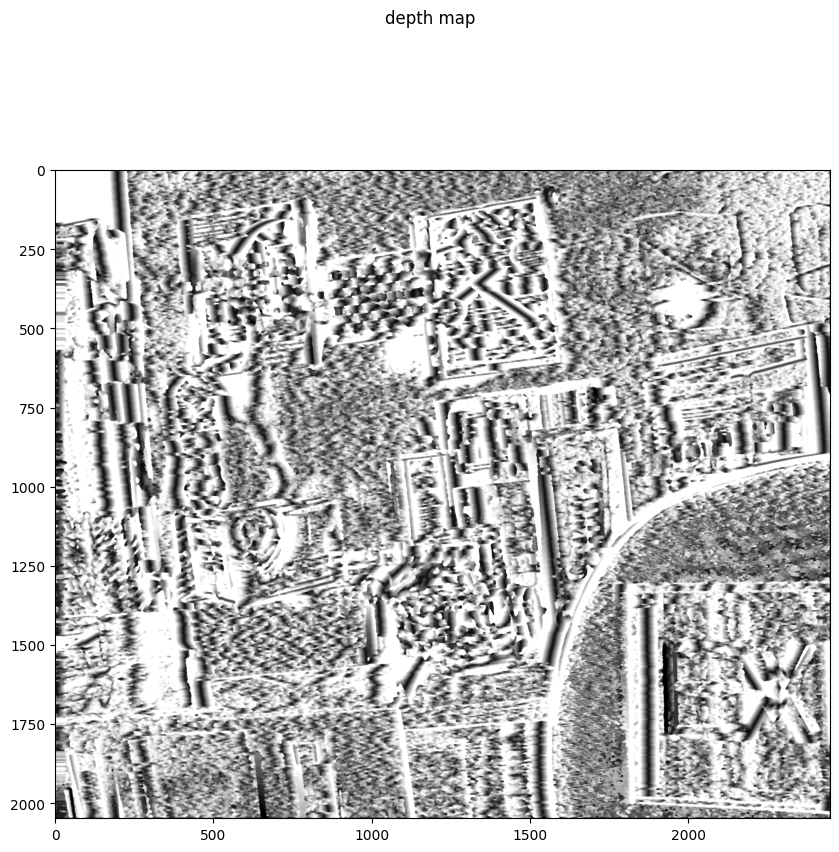

In [ ]:

plt.figure(figsize=(10, 10),linewidth=2.0)
plt.imshow(depth, "gray")
plt.suptitle("depth map")
plt.show()

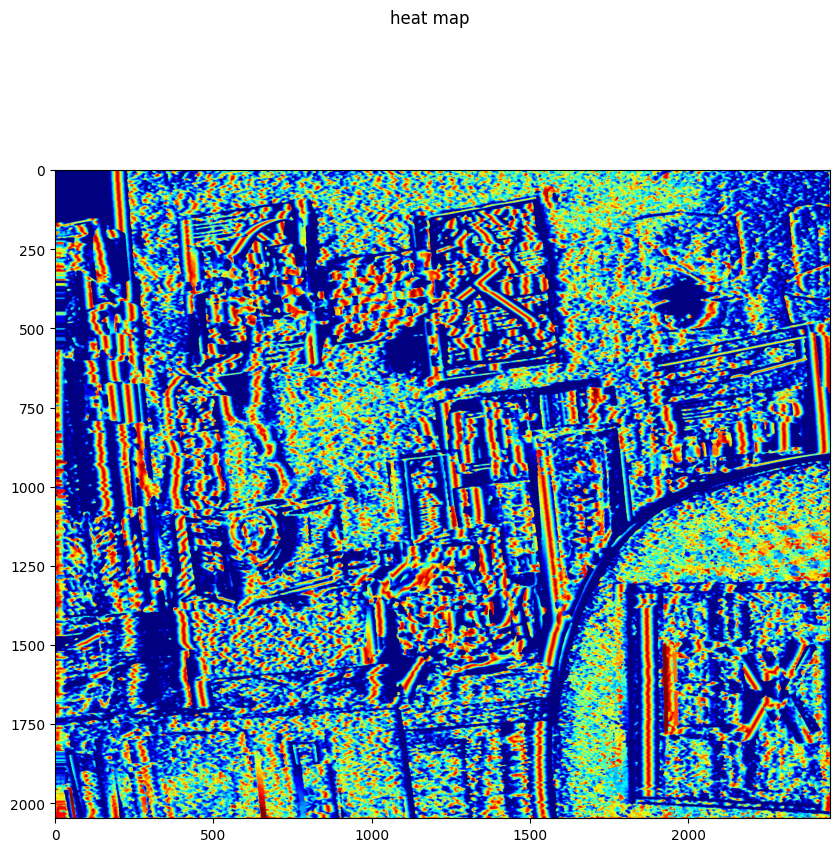

In [ ]:
plt.figure(figsize=(10, 10),linewidth=2.0)
plt.imshow(heatmap)
plt.suptitle("heat map")
plt.show()